In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from src.preprocessing import MinMaxNormalizer, LabelEncoder, DataSplitter, DataPreprocessor
from src.models import XGBoostModel
from src.evaluation import CrossValidator, HyperparameterTuner, MetricsCalculator
from src.visualization import (
    ConfusionMatrixPlotter, ROCCurvePlotter,
    ParameterInfluencePlotter, PredictionScatterPlotter
)

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._search")
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-darkgrid')

output_dir = 'wine_xgb_output'
os.makedirs(output_dir, exist_ok=True)
print(f"✓ Utworzono katalog wyników: {output_dir}")

polish_labels = {
    'fixed acidity': 'Kwasowość stała',
    'volatile acidity': 'Lotna kwasowość',
    'citric acid': 'Kwas cytrynowy',
    'residual sugar': 'Cukier resztkowy',
    'chlorides': 'Chlorki',
    'free sulfur dioxide': 'Wolny dwutlenek siarki',
    'total sulfur dioxide': 'Całkowity dwutlenek siarki',
    'density': 'Gęstość',
    'pH': 'pH',
    'sulphates': 'Siarczany',
    'alcohol': 'Alkohol',
    'quality': 'Jakość'
}

def pl(col):
    return polish_labels.get(col, col)

✓ Utworzono katalog wyników: wine_xgb_output


## 1. Wczytanie i Przetwarzanie Danych


In [2]:
df = pd.read_csv('datasets/winequality.csv')

for col_to_drop in ['name', 'wine_type']:
    if col_to_drop in df.columns:
        print(f"Usuwam kolumnę '{col_to_drop}' – nieużywana do predykcji jakości.")
        df.drop(columns=[col_to_drop], inplace=True)

X = df.drop('quality', axis=1)
y = df['quality']

print(f"Rozmiar zbioru: {X.shape}")
print(f"Klasy (jakość wina): {sorted(y.unique())}")
print("\nRozkład klas (liczebność / procent):")
class_counts = y.value_counts().sort_index()
class_df = class_counts.rename('liczebność').to_frame()
class_df['procent'] = class_df['liczebność'] / len(y) * 100
for quality, row in class_df.iterrows():
    print(f"  Jakość {quality}: {row.liczebność} ({row.procent:.2f}%)")
class_df.to_csv(f"{output_dir}/class_distribution.csv")
print(f"✓ Zapisano rozkład klas: {output_dir}/class_distribution.csv")

print("\nPrzykładowe 5 wierszy (oryginalne nazwy kolumn):")
print(df.head())

print("\nMapa etykiet kolumn (ang -> pl):")
for col in X.columns:
    print(f"  {col} -> {pl(col)}")

Usuwam kolumnę 'wine_type' – nieużywana do predykcji jakości.
Rozmiar zbioru: (6497, 11)
Klasy (jakość wina): [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Rozkład klas (liczebność / procent):
  Jakość 3: 30.0 (0.46%)
  Jakość 4: 216.0 (3.32%)
  Jakość 5: 2138.0 (32.91%)
  Jakość 6: 2836.0 (43.65%)
  Jakość 7: 1079.0 (16.61%)
  Jakość 8: 193.0 (2.97%)
  Jakość 9: 5.0 (0.08%)
✓ Zapisano rozkład klas: wine_xgb_output/class_distribution.csv

Przykładowe 5 wierszy (oryginalne nazwy kolumn):
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.

In [3]:
splitter = DataSplitter(test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = splitter.split(X, y)

normalizer = MinMaxNormalizer()
label_encoder = LabelEncoder()
preprocessor = DataPreprocessor(normalizer, label_encoder)

X_train_norm, X_test_norm = preprocessor.preprocess_features(X_train, X_test)
y_train_enc, y_test_enc = preprocessor.preprocess_labels(y_train, y_test)

print(f"Zbiór treningowy: {X_train_norm.shape}")
print(f"Zbiór testowy: {X_test_norm.shape}")
print(f"Liczba klas: {preprocessor.get_num_classes()}")

quality_label_map = {int(q): f'Jakość {int(q)}' for q in sorted(y.unique())}
encoded_class_labels = {}
if getattr(preprocessor.label_encoder, 'classes_', None) is not None:
    for original_label in preprocessor.label_encoder.classes_:
        encoded_val = int(preprocessor.label_encoder.encoder.transform([original_label])[0])
        encoded_class_labels[encoded_val] = quality_label_map.get(int(original_label), f'Jakość {original_label}')
class_display_names = [encoded_class_labels.get(idx, str(idx)) for idx in range(preprocessor.get_num_classes())]
metric_name_map = {
    'accuracy': 'Dokładność',
    'precision': 'Precyzja',
    'recall': 'Czułość',
    'f1_score': 'Miara F1',
    'roc_auc': 'ROC-AUC',
    'mse': 'MSE',
    'mae': 'MAE',
    'rmse': 'RMSE'
}

Zbiór treningowy: (5847, 11)
Zbiór testowy: (650, 11)
Liczba klas: 7


## 2. Walidacja Krzyżowa (5-Fold CV)


In [4]:
xgb_model = XGBoostModel(n_estimators=100, random_state=42)
cv = CrossValidator(n_splits=5, random_state=42)
cv_scores = cv.validate(xgb_model, X_train_norm, y_train_enc)

print("Wyniki walidacji krzyżowej (5-fold):")
print("="*50)
for metric, score in cv_scores.items():
    print(f"{metric:25s}: {score:.4f}")

Wyniki walidacji krzyżowej (5-fold):
accuracy_mean            : 0.6634
accuracy_std             : 0.0138
precision_macro_mean     : 0.5276
precision_macro_std      : 0.0601
recall_macro_mean        : 0.3970
recall_macro_std         : 0.0347
f1_macro_mean            : 0.4279
f1_macro_std             : 0.0390


## 3. Optymalizacja Hiperparametrów


In [5]:
tuner = HyperparameterTuner(search_type='grid', cv=5)
param_space = xgb_model.get_param_grid()
print("Rozpoczynam optymalizację hiperparametrów...")
xgb_model, cv_results = tuner.tune(xgb_model, X_train_norm, y_train_enc, param_space)
print(f"\nNajlepsze parametry: {tuner.best_params_}")
print(f"Najlepszy wynik CV: {tuner.best_score_:.4f}")
cv_df = pd.DataFrame(cv_results)
if 'mean_test_neg_mean_squared_error' in cv_df.columns:
    cv_df['mean_test_mse'] = -cv_df['mean_test_neg_mean_squared_error']
    cv_df['std_test_mse'] = cv_df.get('std_test_neg_mean_squared_error', np.nan)
if 'mean_test_neg_mean_absolute_error' in cv_df.columns:
    cv_df['mean_test_mae'] = -cv_df['mean_test_neg_mean_absolute_error']
    cv_df['std_test_mae'] = cv_df.get('std_test_neg_mean_absolute_error', np.nan)
cv_df.to_csv(f"{output_dir}/xgb_hyperparam_cv_results_raw.csv", index=False)
print(f"✓ Zapisano wyniki CV: {output_dir}/xgb_hyperparam_cv_results_raw.csv")
if 'rank_test_accuracy' in cv_df.columns:
    best_idx = int(cv_df['rank_test_accuracy'].idxmin())
else:
    best_idx = int(cv_df['mean_test_accuracy'].idxmax())
best_row = cv_df.loc[best_idx]
best_cv_metrics = {}
summary_metrics = {
    'mean_test_accuracy': 'accuracy',
    'mean_test_precision_macro': 'precision_macro',
    'mean_test_recall_macro': 'recall_macro',
    'mean_test_roc_auc_ovr': 'roc_auc_ovr',
    'mean_test_mse': 'mse',
    'mean_test_mae': 'mae'
}
for col, name in summary_metrics.items():
    if col in best_row and pd.notna(best_row[col]):
        best_cv_metrics[f"{name}_mean"] = float(best_row[col])
print("Wybrane metryki najlepszego modelu (CV):")
for key, value in best_cv_metrics.items():
    print(f"  {key}: {value:.4f}")

Rozpoczynam optymalizację hiperparametrów...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Najlepsze parametry: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Najlepszy wynik CV: 0.6836
✓ Zapisano wyniki CV: wine_xgb_output/xgb_hyperparam_cv_results_raw.csv
Wybrane metryki najlepszego modelu (CV):
  accuracy_mean: 0.6836
  precision_macro_mean: 0.4984
  recall_macro_mean: 0.3581
  mse_mean: 0.4438
  mae_mean: 0.3566

Najlepsze parametry: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Najlepszy wynik CV: 0.6836
✓ Zapisano wyniki CV: wine_xgb_output/xgb_hyperparam_cv_results_raw.csv
Wybrane metryki najlepszego modelu (CV):
  accuracy_mean: 0.6836
  precision_macro_mean: 0.4984
  recall_macro_mean: 0.3581
  mse_mean: 0.4438
  mae_mean: 0.3566


✓ Zapisano: wine_xgb_output/xgb_epoki_metryki.csv


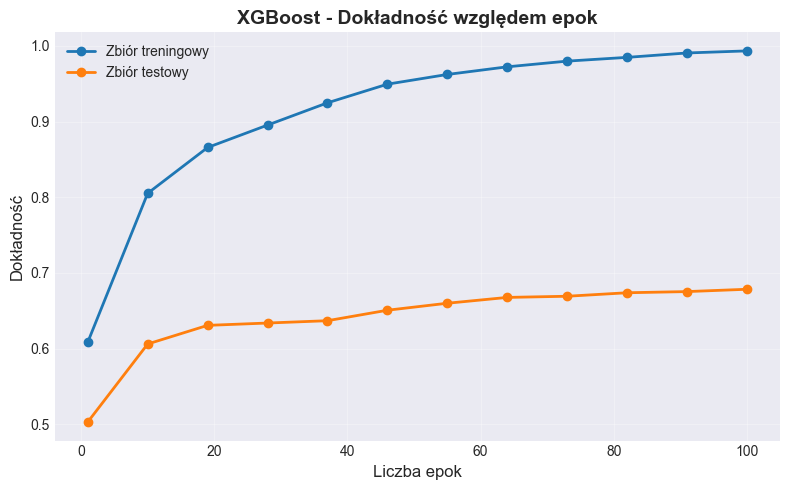

✓ Zapisano: wine_xgb_output/xgb_epoki_dokładność.png


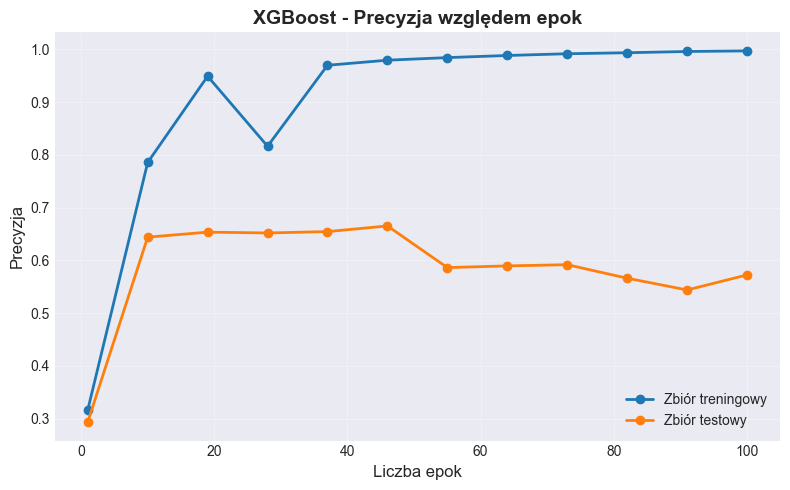

✓ Zapisano: wine_xgb_output/xgb_epoki_precyzja.png


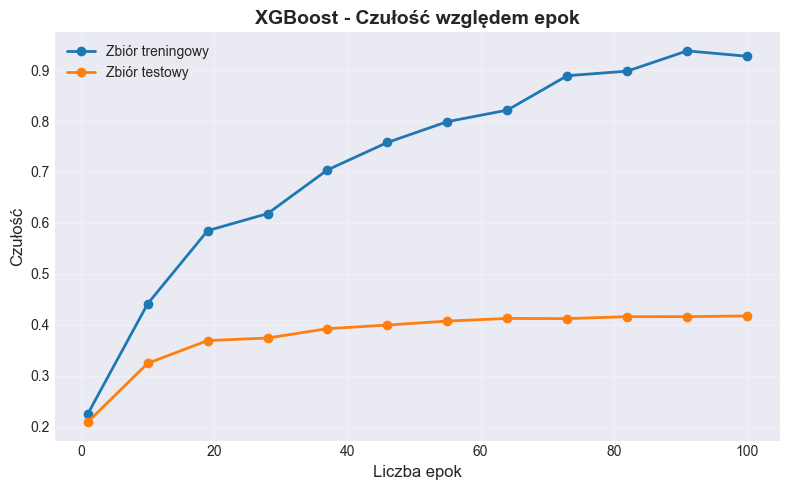

✓ Zapisano: wine_xgb_output/xgb_epoki_czułość.png


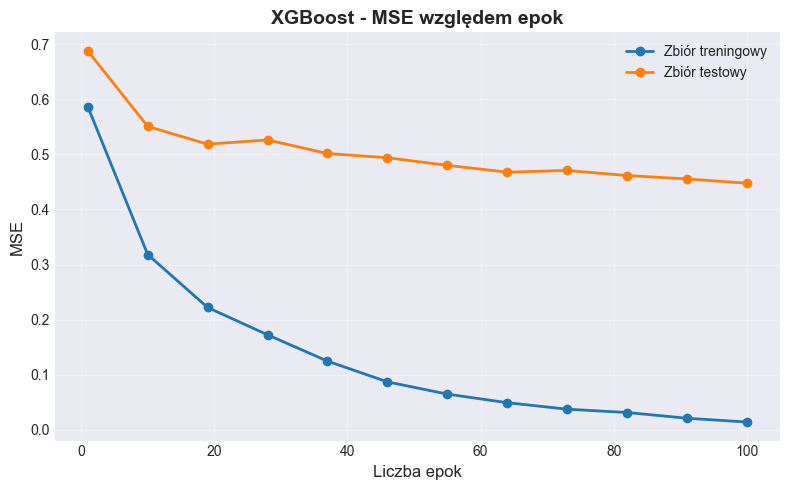

✓ Zapisano: wine_xgb_output/xgb_epoki_mse.png


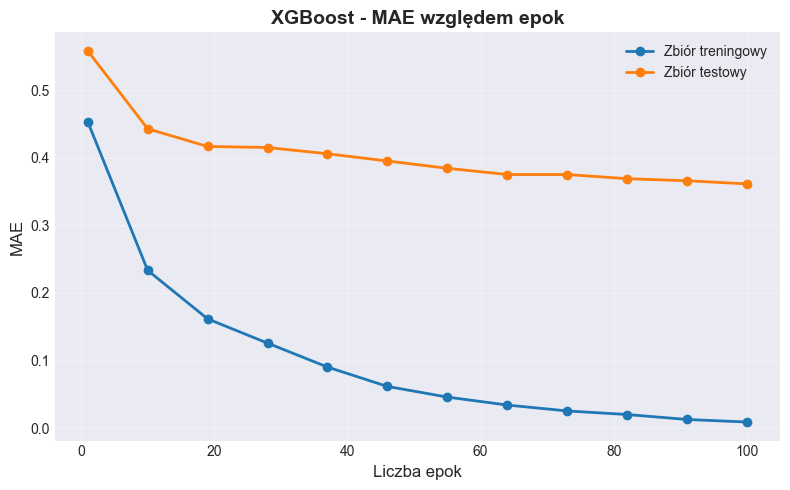

✓ Zapisano: wine_xgb_output/xgb_epoki_mae.png


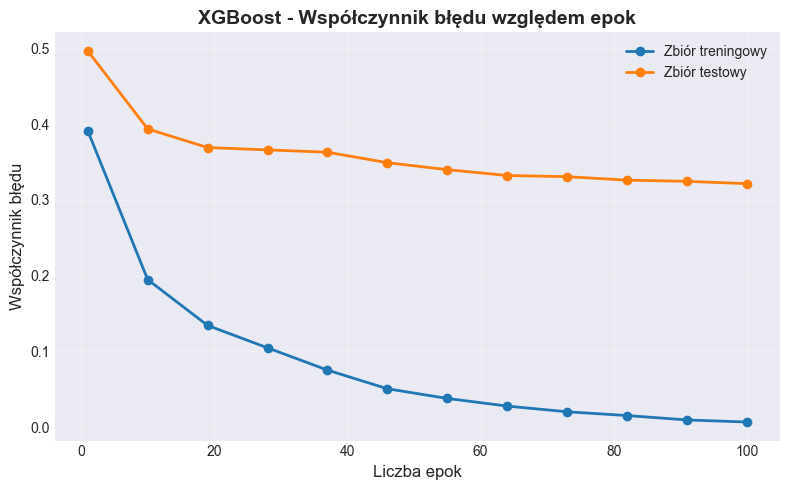

✓ Zapisano: wine_xgb_output/xgb_epoki_blad.png


In [6]:
from xgboost import XGBClassifier
metrics_calc_epoch = MetricsCalculator(average='macro')
base_params = xgb_model.get_params()
max_epochs = int(base_params.get('n_estimators', 100))
epoch_values = np.linspace(1, max_epochs, num=min(max_epochs, 12), dtype=int)
epoch_values = np.unique(epoch_values)
epoch_records = []
for epoch in epoch_values:
    params = base_params.copy()
    params['n_estimators'] = int(epoch)
    estimator = XGBClassifier(**params)
    estimator.fit(X_train_norm, y_train_enc, verbose=False)
    for subset_name, X_subset, y_subset in [('Trening', X_train_norm, y_train_enc), ('Test', X_test_norm, y_test_enc)]:
        preds = estimator.predict(X_subset)
        probas = estimator.predict_proba(X_subset)
        classification = metrics_calc_epoch.calculate_classification_metrics(y_subset, preds)
        errors = metrics_calc_epoch.calculate_error_metrics(y_subset, preds)
        roc_auc_val = metrics_calc_epoch.calculate_roc_auc(y_subset, probas)
        if roc_auc_val is None:
            roc_auc_val = np.nan
        epoch_records.append({
            'Epoka': int(epoch),
            'Zestaw': subset_name,
            'Dokładność': classification['accuracy'],
            'Precyzja': classification['precision'],
            'Czułość': classification['recall'],
            'ROC_AUC': roc_auc_val,
            'MSE': errors['mse'],
            'MAE': errors['mae']
        })
epoch_metrics_df = pd.DataFrame(epoch_records)
epoch_metrics_df['Współczynnik błędu'] = 1.0 - epoch_metrics_df['Dokładność']
epoch_metrics_df.to_csv(f"{output_dir}/xgb_epoki_metryki.csv", index=False)
print(f"✓ Zapisano: {output_dir}/xgb_epoki_metryki.csv")
label_map = {'Trening': 'Zbiór treningowy', 'Test': 'Zbiór testowy'}
metrics_to_plot = [
    ('Dokładność', 'XGBoost - Dokładność względem epok'),
    ('Precyzja', 'XGBoost - Precyzja względem epok'),
    ('Czułość', 'XGBoost - Czułość względem epok'),
    ('MSE', 'XGBoost - MSE względem epok'),
    ('MAE', 'XGBoost - MAE względem epok')
]
for metric_name, plot_title in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for dataset_name in ['Trening', 'Test']:
        subset = epoch_metrics_df.loc[epoch_metrics_df['Zestaw'] == dataset_name]
        plt.plot(subset['Epoka'], subset[metric_name], marker='o', linewidth=2, label=label_map[dataset_name])
    plt.title(plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Liczba epok', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/xgb_epoki_{metric_name.lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Zapisano: {output_dir}/xgb_epoki_{metric_name.lower()}.png")
plt.figure(figsize=(8, 5))
for dataset_name in ['Trening', 'Test']:
    subset = epoch_metrics_df.loc[epoch_metrics_df['Zestaw'] == dataset_name]
    plt.plot(subset['Epoka'], subset['Współczynnik błędu'], marker='o', linewidth=2, label=label_map[dataset_name])
plt.title('XGBoost - Współczynnik błędu względem epok', fontsize=14, fontweight='bold')
plt.xlabel('Liczba epok', fontsize=12)
plt.ylabel('Współczynnik błędu', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_epoki_blad.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/xgb_epoki_blad.png")

## 4. Trening Finalnego Modelu


In [7]:
xgb_model.fit(X_train_norm, y_train_enc)
training_time = xgb_model.get_training_time()

print(f"Model wytrenowany pomyślnie!")
print(f"Czas treningu: {training_time:.3f} sekund")

Model wytrenowany pomyślnie!
Czas treningu: 1.321 sekund


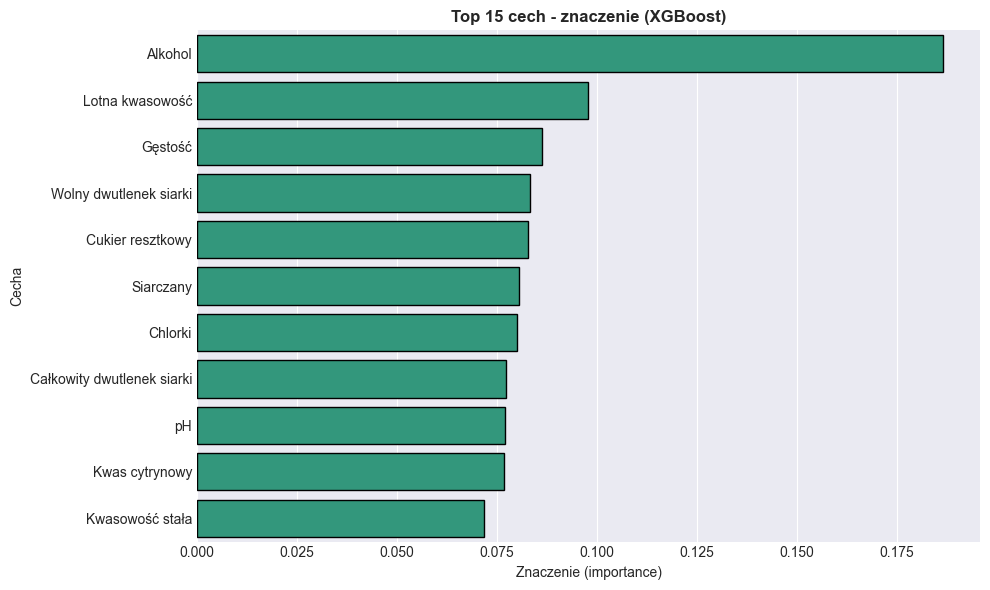

✓ Zapisano: wine_xgb_output/feature_importances.csv oraz feature_importances_top15.png


In [8]:
if hasattr(xgb_model.model, 'feature_importances_'):
    importances = xgb_model.model.feature_importances_
    feat_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    feat_df['feature_pl'] = feat_df['feature'].apply(pl)
    feat_df.to_csv(f"{output_dir}/feature_importances.csv", index=False)
    plt.figure(figsize=(10,6))
    sns.barplot(
        x='importance',
        y='feature_pl',
        data=feat_df.head(15),
        color=plt.colormaps.get('viridis')(0.6),
        edgecolor='black'
    )
    plt.title('Top 15 cech - znaczenie (XGBoost)', fontweight='bold')
    plt.xlabel('Znaczenie (importance)')
    plt.ylabel('Cecha')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_importances_top15.png", dpi=300)
    plt.show()
    print(f"✓ Zapisano: {output_dir}/feature_importances.csv oraz feature_importances_top15.png")
else:
    print("⚠ Brak atrybutu feature_importances_ w modelu")

## 5. Ewaluacja na Zbiorze Testowym


In [9]:
y_pred = xgb_model.predict(X_test_norm)
y_pred_proba = xgb_model.predict_proba(X_test_norm)

metrics_calc = MetricsCalculator(average='macro')
metrics = metrics_calc.calculate_all_metrics(y_test_enc, y_pred, y_pred_proba)

print("Metryki na zbiorze testowym:")
print("="*50)
for metric_key, value in metrics.items():
    if metric_key == 'confusion_matrix':
        continue
    metric_label = metric_name_map.get(metric_key, metric_key)
    if value is None:
        print(f"{metric_label:25s}: brak danych")
    elif isinstance(value, (int, float, np.floating)):
        print(f"{metric_label:25s}: {float(value):.4f}")
    else:
        print(f"{metric_label:25s}: {value}")

Metryki na zbiorze testowym:
Dokładność               : 0.6785
Precyzja                 : 0.5725
Czułość                  : 0.4173
MSE                      : 0.4477
MAE                      : 0.3615
RMSE                     : 0.6691


## 6. Wizualizacje


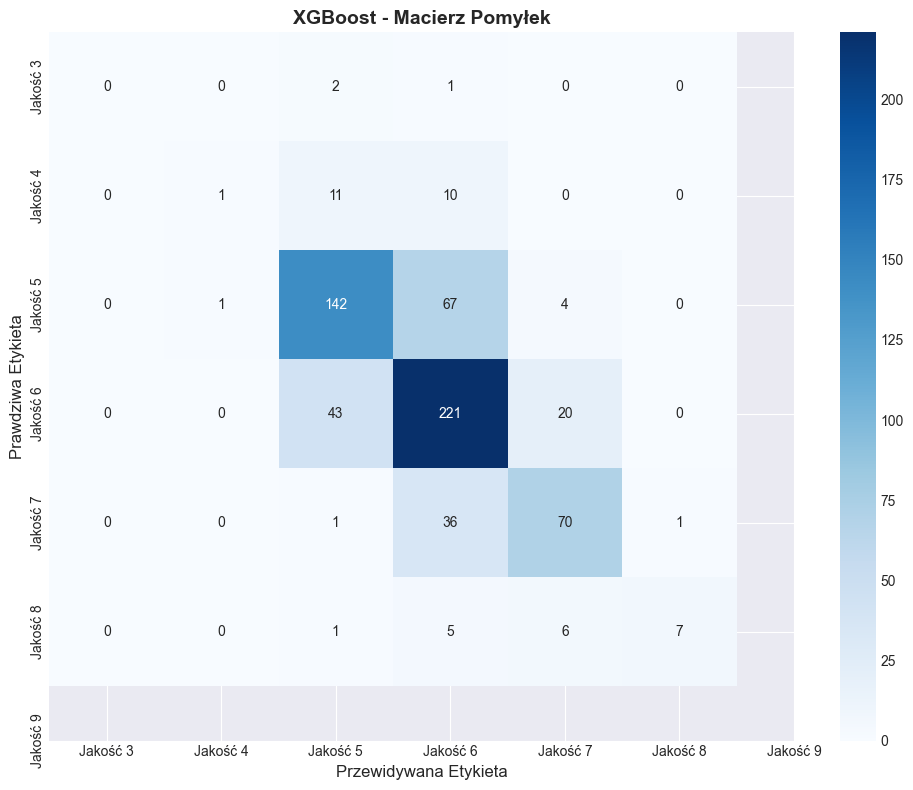

✓ Zapisano: wine_xgb_output/confusion_matrix.png


In [10]:
cm_plotter = ConfusionMatrixPlotter(figsize=(10, 8))
fig = cm_plotter.plot(metrics['confusion_matrix'],
                     class_names=class_display_names,
                     title='XGBoost - Macierz Pomyłek')
fig.savefig(f"{output_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/confusion_matrix.png")

/Users/maksymiliansowula/Documents/Studia/2semestrmgr/Analiza i Wizualizacja Danych/Poczęta - Projekt/AWD/.venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


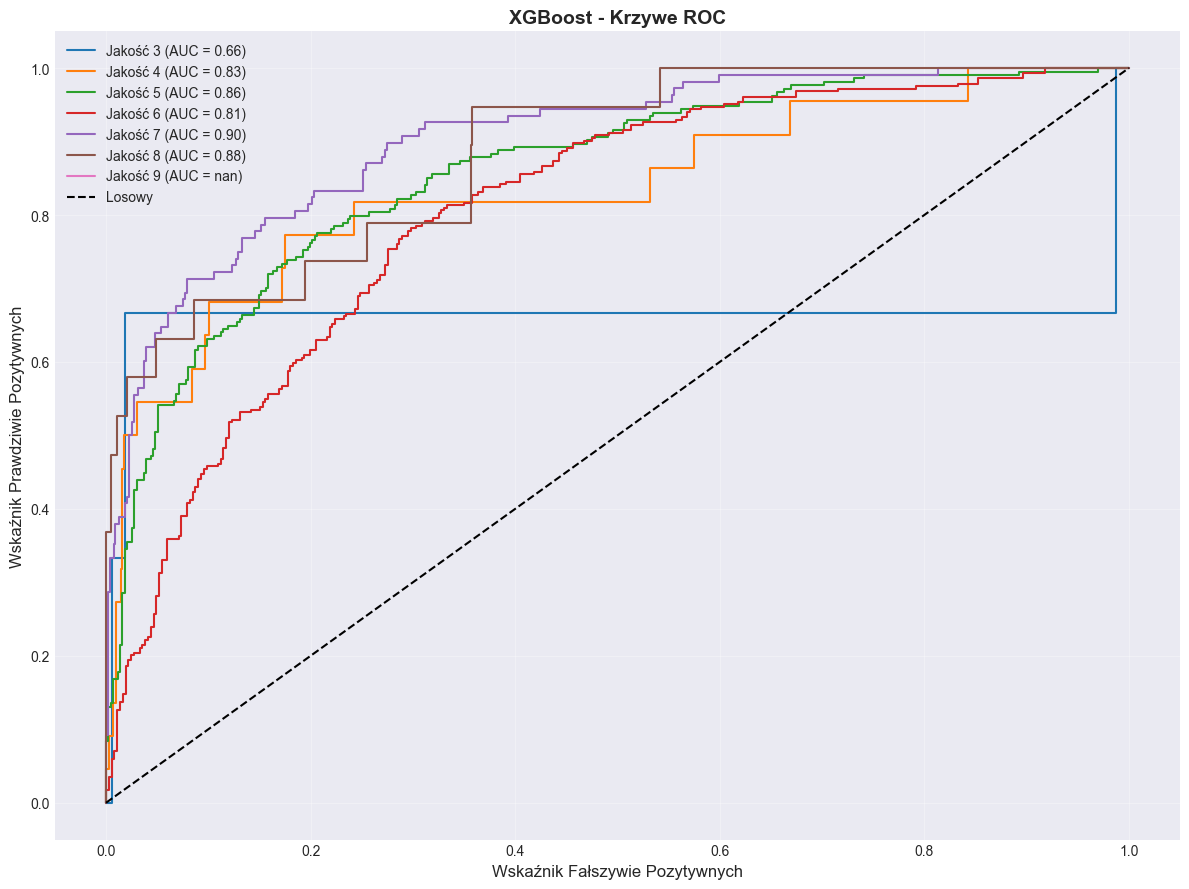

✓ Zapisano: wine_xgb_output/roc_curves.png


In [11]:
roc_plotter = ROCCurvePlotter(figsize=(12, 9))
n_classes = preprocessor.get_num_classes()
fig = roc_plotter.plot(y_test_enc, y_pred_proba, n_classes,
                      title='XGBoost - Krzywe ROC',
                      class_names=class_display_names)
fig.savefig(f"{output_dir}/roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/roc_curves.png")

In [12]:
from sklearn.metrics import classification_report

all_encoded_labels = np.arange(preprocessor.get_num_classes())
report = classification_report(
    y_test_enc,
    y_pred,
    target_names=class_display_names,
    labels=all_encoded_labels,
    zero_division=0
)
with open(f"{output_dir}/classification_report.txt","w") as f:
    f.write(report)
print("\nRaport klasyfikacji:")
print(report)
print(f"✓ Zapisano: {output_dir}/classification_report.txt")

mis_idx = np.where(y_test_enc != y_pred)[0]
print(f"\nLiczba błędnie sklasyfikowanych próbek: {len(mis_idx)} ({len(mis_idx)/len(y_test_enc)*100:.2f}%)")

def decode_label(idx):
    idx = int(idx)
    if 0 <= idx < len(class_display_names):
        return class_display_names[idx]
    return str(idx)

sample_df = pd.DataFrame({
    'Klasa rzeczywista': [decode_label(idx) for idx in y_test_enc[:15]],
    'Klasa przewidywana': [decode_label(idx) for idx in y_pred[:15]],
    'Prawdopodobieństwo': y_pred_proba[:15].max(axis=1)
})
sample_df.to_csv(f"{output_dir}/sample_predictions_head15.csv", index=False)
print(f"\nPrzykładowe predykcje (pierwsze 15):")
print(sample_df)
print(f"✓ Zapisano: {output_dir}/sample_predictions_head15.csv")


Raport klasyfikacji:
              precision    recall  f1-score   support

    Jakość 3       0.00      0.00      0.00         3
    Jakość 4       0.50      0.05      0.08        22
    Jakość 5       0.71      0.66      0.69       214
    Jakość 6       0.65      0.78      0.71       284
    Jakość 7       0.70      0.65      0.67       108
    Jakość 8       0.88      0.37      0.52        19
    Jakość 9       0.00      0.00      0.00         0

    accuracy                           0.68       650
   macro avg       0.49      0.36      0.38       650
weighted avg       0.68      0.68      0.67       650

✓ Zapisano: wine_xgb_output/classification_report.txt

Liczba błędnie sklasyfikowanych próbek: 209 (32.15%)

Przykładowe predykcje (pierwsze 15):
   Klasa rzeczywista Klasa przewidywana  Prawdopodobieństwo
0           Jakość 6           Jakość 7            0.682169
1           Jakość 5           Jakość 5            0.619376
2           Jakość 4           Jakość 4            0.86

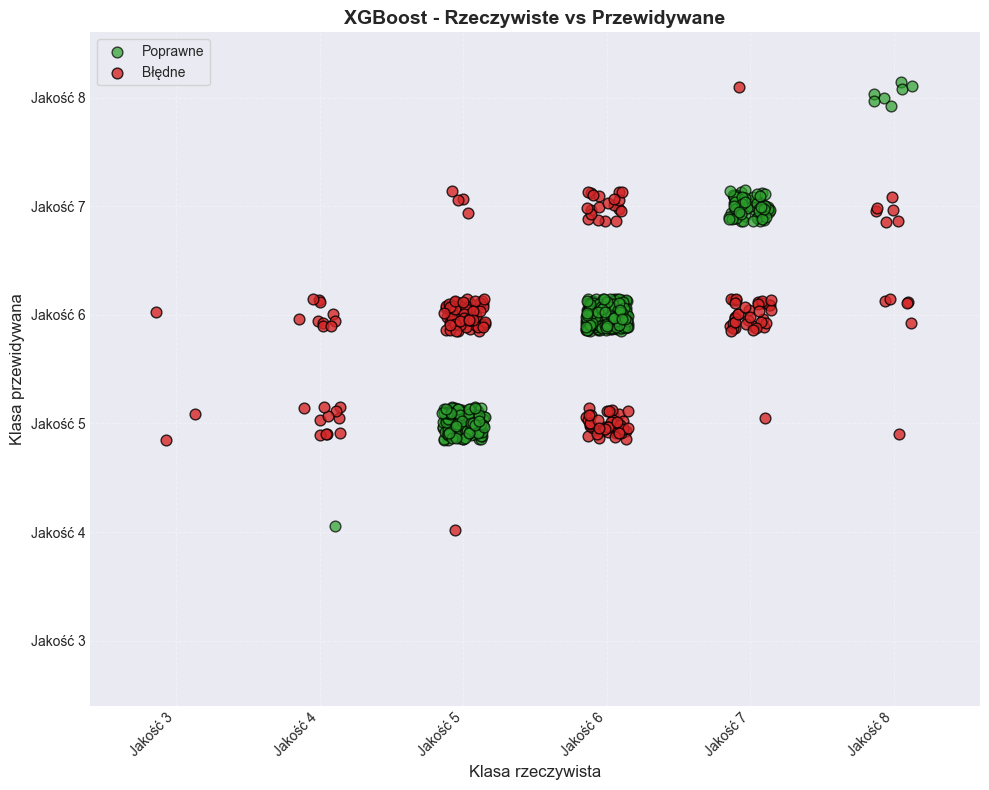

✓ Zapisano: wine_xgb_output/prediction_scatter.png


In [13]:
scatter_plotter = PredictionScatterPlotter(figsize=(10, 8))
fig = scatter_plotter.plot(y_test_enc, y_pred,
                          title='XGBoost - Rzeczywiste vs Przewidywane',
                          class_labels=encoded_class_labels)
fig.savefig(f"{output_dir}/prediction_scatter.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/prediction_scatter.png")

## 7. Podsumowanie


In [14]:
print("="*60)
print("PODSUMOWANIE - XGBOOST")
print("="*60)
print(f"\nParametry modelu: {tuner.best_params_}")
print(f"\nWyniki CV (5-fold):")
for metric, score in best_cv_metrics.items():
    if 'mean' in metric:
        print(f"  {metric}: {score:.4f}")
print(f"\nWyniki testowe:")
print(f"  Dokładność: {metrics['accuracy']:.4f}")
print(f"  Precyzja: {metrics['precision']:.4f}")
print(f"  Czułość: {metrics['recall']:.4f}")
print(f"  ROC-AUC: {metrics.get('roc_auc', 'N/A')}")
print(f"\nCzas treningu: {training_time:.3f}s")
print("="*60)

PODSUMOWANIE - XGBOOST

Parametry modelu: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}

Wyniki CV (5-fold):
  accuracy_mean: 0.6836
  precision_macro_mean: 0.4984
  recall_macro_mean: 0.3581
  mse_mean: 0.4438
  mae_mean: 0.3566

Wyniki testowe:
  Dokładność: 0.6785
  Precyzja: 0.5725
  Czułość: 0.4173
  ROC-AUC: N/A

Czas treningu: 1.321s
